In [1]:
# Notebook to evaluate the distribution of fact check lengths to determine appropriate token length for Gemma
# Add library support
import pandas as pd
import jsonlines
import json
pd.set_option('display.max_colwidth', None)
from tqdm import tqdm
tqdm.pandas()
# Test whether checkthat parsing works correctly
from claimrobustness import utils, defaults
import importlib
importlib.reload(utils)
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

/data/kebl7383/claimrobust/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the targets
# Load the test data used for generating misinformation edits
data = utils.load_data(dataset='fact-check-tweet')
test_queries, test_qrels = data["test"]
targets = data["targets"]

In [3]:
targets.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59951 entries, 0 to 86375
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      59951 non-null  object
 1   subtitle   59951 non-null  object
 2   author     59951 non-null  object
 3   date       34873 non-null  object
 4   target_id  59951 non-null  object
 5   url        59951 non-null  object
 6   target     59951 non-null  object
 7   lang       59951 non-null  object
dtypes: object(8)
memory usage: 4.1+ MB


In [4]:
targets.index

Index([    0,     1,     6,     7,    10,    11,    12,    13,    14,    15,
       ...
       86363, 86364, 86365, 86366, 86368, 86370, 86371, 86372, 86374, 86375],
      dtype='int64', length=59951)

In [7]:
test_ranks.shape

(104, 59951)

In [8]:
targets.shape

(59951, 8)

In [9]:
sample_rank = test_ranks[0]

In [12]:
sample_rank[:10]

array([40398, 24568, 49912, 11417, 43762, 40350, 28979, 14852, 48430,
       17395])

In [10]:
targets.index.max()

np.int64(86375)

In [20]:
np.array(sample_rank).max()

np.int64(59950)

In [18]:
# Check how many indices in sample_rank are present in targets.index
present_indices = [idx for idx in sample_rank if idx in targets.index]
num_present_indices = len(present_indices)

print(f"Number of indices in sample_rank that are present in targets.index: {num_present_indices}")

Number of indices in sample_rank that are present in targets.index: 41758


In [6]:
import torch
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('BAAI/bge-reranker-v2-gemma')

In [12]:
train_sentences = targets['target'].to_numpy()

In [15]:
# Print the original sentence.
print(' Original: ', train_sentences[11])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(train_sentences[10]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(train_sentences[10])))

 Original:  Facebook (FB) page Hugpong ng Pagbabago posted on Aug. 25 a graphic quoting former senator Paolo Benigno “Bam” Aquino as saying: “It is an open fact that Aquino is a family of heroes.”

This is fake. There are no records of Aquino saying such a thing, based on a review of several video interviews, press releases and news reports.

The fabricated quote was superimposed on a screengrab of the former lawmaker during a Jan. 4, 2018 episode of CNN Philippines’ The Source. Placed above it was a sarcastic phrase reading, “Wow lakas maka-bayani (strong hero vibes),” a “Kapow!” sticker and a laughing emoji.

Aquino made no mention of his family during the 30-minute-long television interview, and neither did he brag about it being “a family of heroes” in fresh news reports and updates on his official social media accounts and website.

A reverse image search shows the exact same graphic circulated as early as March 2018 on Twitter, while blog The Philippine Pride (phnewspride.blogspo

In [16]:
# Measure the maximum length of the sentences
max_len = 0
lengths_en = []
# For every sentence...
for sent in train_sentences:
    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    # Record the length.
    lengths_en.append(len(input_ids))
    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))
print('Max sentence length: ', max_len)

Max sentence length:  5201


In [17]:
import numpy as np 

In [18]:
print('Min length: {:,} tokens'.format(min(lengths_en)))
print('Max length: {:,} tokens'.format(max(lengths_en)))
print('Median length: {:,} tokens'.format(int(np.median(lengths_en))))

Min length: 6 tokens
Max length: 5,201 tokens
Median length: 705 tokens


/tmp/ipykernel_3354499/3209623177.py:18: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(lengths_en, kde=False, rug=False, hist_kws={'alpha': 1, 'edgecolor': 'black'})


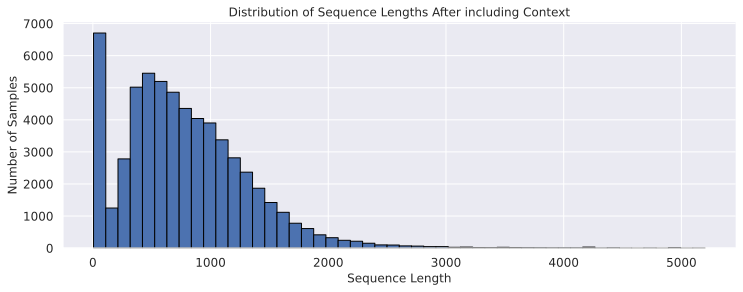

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize the distribution of sequence lengths

custom_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

# Set style for scientific publications
sns.set_theme(style='white', font_scale=1.0)  # Reduced font scale
sns.set_palette("Set2")

# Increase the plot size and font size
sns.set(font_scale=1)
# Create the plot with a white background
plt.figure(figsize=(10.5, 4.27), facecolor='white')

# Plot the distribution of sequence lengths without grids
sns.distplot(lengths_en, kde=False, rug=False, hist_kws={'alpha': 1, 'edgecolor': 'black'})

# Add title and labels
plt.title('Distribution of Sequence Lengths After including Context')
plt.xlabel('Sequence Length')
plt.ylabel('Number of Samples')

# Emphasize the x-axis and y-axis
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Keep only left and bottom border lines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)

# Display the plot
plt.tight_layout()  # Ensures labels don't overlap
# plt.savefig("sequence_lengths_distribution_with_context.svg", dpi=300)  # Save the figure
plt.show()

In [33]:
2048

2048

In [34]:
max_len = 2048

# Count the number of sequences that are longer than `max_len` tokens.
num_truncated = np.sum(np.greater(lengths_en, max_len))

# Compare this to the total number of training sentences.
num_sentences = len(lengths_en)
prcnt = float(num_truncated) / float(num_sentences)

print('{:,} of {:,} sentences ({:.1%}) in the training set are longer than {:} tokens.'.format(num_truncated, num_sentences, prcnt, max_len))

1,394 of 59,951 sentences (2.3%) in the training set are longer than 2048 tokens.


In [25]:
# Check the maximum length
max_length = tokenizer.model_max_length
print(f"Maximum tokenizer length: {max_length}")

Maximum tokenizer length: 1000000000000000019884624838656
